<a href="https://colab.research.google.com/github/CalvinXKY/InfraTech/blob/main/llm_infer/vllm_basic_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 从零搭建LLM调度器

Build an LLM Scheduler from Scratch

Author: kaiyuan

Email: kyxie@zju.edu.cn

# 1 输入与生成
## 1.1 从prompts到tokens的转换

方式1：使用transformers模块的AutoTokenizer

In [1]:
# 定义tokenizer:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B", use_fast=True)
prompts = [
    "hi, I'm kaiyuan",
    "Do you subscribe InfraTech?",
]
prompts = [
    tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True,
    )
    for prompt in prompts
]
for prompt in prompts:
    print(tokenizer.encode(prompt))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[151644, 872, 198, 6023, 11, 358, 2776, 595, 2143, 88, 10386, 151645, 198, 151644, 77091, 198]
[151644, 872, 198, 5404, 498, 17963, 14921, 956, 34097, 30, 151645, 198, 151644, 77091, 198]


方式2： 构建一个随机整数输出，充当tokens。

In [2]:
import numpy as np
np.random.seed(0)

def generate_random_int_tokens(min_len: int = 1, max_len: int = 10, min_val: int = 1, max_val: int = 999):
    """
    生成一个包含随机整数的数组。

    Args:
        min_len (int): 数组的最小长度。
        max_len (int): 数组的最大长度。
        min_val (int): 数组中整数的最小值（包含）。
        max_val (int): 数组中整数的最大值（包含）。

    Returns:
        list: 包含随机整数的数组。
    """
    if min_len > max_len:
        raise ValueError("min_len must be less than or equal to max_len")
    if min_val > max_val:
        raise ValueError("min_val must be less than or equal to max_val")

    array_length = np.random.randint(min_len, max_len + 1)
    random_array = [np.random.randint(min_val, max_val + 1) for _ in range(array_length)]
    return random_array


default_array = generate_random_int_tokens()
print(default_array)

[193, 836, 764, 708, 360, 10]


## 1.2 构造一个模拟的LLM
构建一个假的模型运算，模拟输入一个提示词，生成一个token。

In [3]:
def run_fake_model(seqs, max_len: int = 15, min_val: int = -1, max_val: int = 999, eos: int=-1):
  token_ids = [eos if len(seq) >= max_len else np.random.randint(min_val, max_val + 1) for seq in seqs]
  return token_ids

In [4]:
# 测试：
seqs = [[536, 332, 844, 933, 736, 476, 87], [1000]]
print(run_fake_model(seqs))

[722, 276]



## 2 辅助函数&类

1、配置文件：

In [5]:
import os
from dataclasses import dataclass


@dataclass
class Config:
    model: str = "dummy"
    max_num_batched_tokens: int = 16384
    max_num_seqs: int = 512
    max_model_len: int = 4096
    gpu_memory_utilization: float = 0.9
    tensor_parallel_size: int = 1
    enforce_eager: bool = False
    eos: int = -1
    kvcache_block_size: int = 256
    num_kvcache_blocks: int = -1

    def __post_init__(self):
        assert self.kvcache_block_size % 256 == 0
        assert 1 <= self.tensor_parallel_size <= 8
        assert self.max_num_batched_tokens >= self.max_model_len

2、采样参数：

In [6]:
from dataclasses import dataclass


@dataclass
class SamplingParams:
    temperature: float = 1.0
    max_tokens: int = 64
    ignore_eos: bool = False


3、 请求序列

用Sequence类承载单个请求的相关信息
* 序列tokens数据，请求状态
* KV cache blocks的使用情况

In [7]:
from copy import copy
from enum import Enum, auto
from itertools import count


class SequenceStatus(Enum):
    WAITING = auto()
    RUNNING = auto()
    FINISHED = auto()


class Sequence:
    block_size = 256
    counter = count()

    def __init__(self, token_ids: list[int], sampling_params = SamplingParams()):
        self.seq_id = next(Sequence.counter)
        self.status = SequenceStatus.WAITING
        self.token_ids = copy(token_ids)
        self.last_token = token_ids[-1]
        self.num_tokens = len(self.token_ids)
        self.num_prompt_tokens = len(token_ids)
        self.num_cached_tokens = 0
        self.block_table = []
        self.temperature = sampling_params.temperature
        self.max_tokens = sampling_params.max_tokens
        self.ignore_eos = sampling_params.ignore_eos

    def __len__(self):
        return self.num_tokens

    def __getitem__(self, key):
        return self.token_ids[key]

    @property
    def is_finished(self):
        return self.status == SequenceStatus.FINISHED

    @property
    def num_completion_tokens(self):
        return self.num_tokens - self.num_prompt_tokens

    @property
    def prompt_token_ids(self):
        return self.token_ids[:self.num_prompt_tokens]

    @property
    def completion_token_ids(self):
        return self.token_ids[self.num_prompt_tokens:]

    @property
    def num_cached_blocks(self):
        return self.num_cached_tokens // self.block_size

    @property
    def num_blocks(self):
        return (self.num_tokens + self.block_size - 1) // self.block_size

    @property
    def last_block_num_tokens(self):
        return self.num_tokens - (self.num_blocks - 1) * self.block_size

    def block(self, i):
        assert 0 <= i < self.num_blocks
        return self.token_ids[i*self.block_size: (i+1)*self.block_size]

    def append_token(self, token_id: int):
        self.token_ids.append(token_id)
        self.last_token = token_id
        self.num_tokens += 1

    def __getstate__(self):
        return (self.num_tokens, self.num_prompt_tokens, self.num_cached_tokens, self.block_table,
                self.token_ids if self.num_completion_tokens == 0 else self.last_token)

    def __setstate__(self, state):
        self.num_tokens, self.num_prompt_tokens, self.num_cached_tokens, self.block_table = state[:-1]
        if self.num_completion_tokens == 0:
            self.token_ids = state[-1]
        else:
            self.last_token = state[-1]

4、KV cache管理器

* paged attention原理管理KV cache。
* 以Block为单位管理KV cache，每个Block包含若干tokens cache空间。
* 统一由BlockManager管理。

In [8]:
from collections import deque
import xxhash
import numpy as np

class Block:

    def __init__(self, block_id):
        self.block_id = block_id
        self.ref_count = 0
        self.hash = -1
        self.token_ids = []

    def update(self, hash: int, token_ids: list[int]):
        self.hash = hash
        self.token_ids = token_ids

    def reset(self):
        self.ref_count = 1
        self.hash = -1
        self.token_ids = []


class BlockManager:

    def __init__(self, num_blocks: int, block_size: int):
        self.block_size = block_size
        self.blocks: list[Block] = [Block(i) for i in range(num_blocks)]
        self.hash_to_block_id: dict[int, int] = dict()
        self.free_block_ids: deque[int] = deque(range(num_blocks))
        self.used_block_ids: set[int] = set()

    @classmethod
    def compute_hash(cls, token_ids: list[int], prefix: int = -1):
        h = xxhash.xxh64()
        if prefix != -1:
            h.update(prefix.to_bytes(8, "little"))
        h.update(np.array(token_ids).tobytes())
        return h.intdigest()

    def _allocate_block(self, block_id: int) -> Block:
        block = self.blocks[block_id]
        assert block.ref_count == 0
        block.reset()
        self.free_block_ids.remove(block_id)
        self.used_block_ids.add(block_id)
        return self.blocks[block_id]

    def _deallocate_block(self, block_id: int) -> Block:
        assert self.blocks[block_id].ref_count == 0
        self.used_block_ids.remove(block_id)
        self.free_block_ids.append(block_id)

    def can_allocate(self, seq: Sequence) -> bool:
        return len(self.free_block_ids) >= seq.num_blocks

    def allocate(self, seq: Sequence):
        assert not seq.block_table
        h = -1
        cache_miss = False
        for i in range(seq.num_blocks):
            token_ids = seq.block(i)
            h = self.compute_hash(token_ids, h) if len(token_ids) == self.block_size else -1
            block_id = self.hash_to_block_id.get(h, -1)
            if block_id == -1 or self.blocks[block_id].token_ids != token_ids:
                cache_miss = True
            if cache_miss:
                block_id = self.free_block_ids[0]
                block = self._allocate_block(block_id)
            else:
                seq.num_cached_tokens += self.block_size
                if block_id in self.used_block_ids:
                    block = self.blocks[block_id]
                    block.ref_count += 1
                else:
                    block = self._allocate_block(block_id)
            if h != -1:
                block.update(h, token_ids)
                self.hash_to_block_id[h] = block_id
            seq.block_table.append(block_id)

    def deallocate(self, seq: Sequence):
        for block_id in reversed(seq.block_table):
            block = self.blocks[block_id]
            block.ref_count -= 1
            if block.ref_count == 0:
                self._deallocate_block(block_id)
        seq.num_cached_tokens = 0
        seq.block_table.clear()

    def can_append(self, seq: Sequence) -> bool:
        return len(self.free_block_ids) >= (len(seq) % self.block_size == 1)

    def may_append(self, seq: Sequence):
        block_table = seq.block_table
        last_block = self.blocks[block_table[-1]]
        if len(seq) % self.block_size == 1:
            assert last_block.hash != -1
            block_id = self.free_block_ids[0]
            self._allocate_block(block_id)
            block_table.append(block_id)
        elif len(seq) % self.block_size == 0:
            assert last_block.hash == -1
            token_ids = seq.block(seq.num_blocks-1)
            prefix = self.blocks[block_table[-2]].hash if len(block_table) > 1 else -1
            h = self.compute_hash(token_ids, prefix)
            last_block.update(h, token_ids)
            self.hash_to_block_id[h] = last_block.block_id
        else:
            assert last_block.hash == -1


## 3 定义Scheduler

scheduler基本功能：
* 支持Continuous-batching
* 可以控制prefill和decode的执行优先级，默认prefill优先；
* decode具备资源不足抢占功能

不考虑prefill和decode混合调度执行。deocde优先时，为非Continuous-batching状态。

In [9]:
from collections import deque

class Scheduler:

    def __init__(self, config: Config):
        self.max_num_seqs = config.max_num_seqs
        self.max_num_batched_tokens = config.max_num_batched_tokens
        self.eos = config.eos
        self.block_manager = BlockManager(config.num_kvcache_blocks, config.kvcache_block_size)
        self.waiting: deque[Sequence] = deque()
        self.running: deque[Sequence] = deque()
        self.num_seqs = 0
        self.num_batched_tokens = 0

    def is_finished(self):
        return not self.waiting and not self.running

    def add(self, seq: Sequence):
        self.waiting.append(seq)

    def prefill(self):
        scheduled_seqs = []
        while self.waiting and self.num_seqs < self.max_num_seqs:
            seq = self.waiting[0]
            if self.num_batched_tokens + len(seq) > self.max_num_batched_tokens or not self.block_manager.can_allocate(seq):
                break
            self.num_seqs += 1
            self.block_manager.allocate(seq)
            self.num_batched_tokens += len(seq) - seq.num_cached_tokens
            seq.status = SequenceStatus.RUNNING
            self.waiting.popleft()
            self.running.append(seq)
            scheduled_seqs.append(seq)
        return scheduled_seqs, True

    def decode(self):
        scheduled_seqs = []
        while self.running and self.num_seqs < self.max_num_seqs:
            seq = self.running.popleft()
            while not self.block_manager.can_append(seq):
                if self.running:
                    self.preempt(self.running.pop())
                else:
                    self.preempt(seq)
                    break
            else:
                self.num_seqs += 1
                self.block_manager.may_append(seq)
                scheduled_seqs.append(seq)
        if scheduled_seqs:
          self.running.extendleft(reversed(scheduled_seqs))
        return scheduled_seqs, False

    def preempt(self, seq: Sequence):
        seq.status = SequenceStatus.WAITING
        self.block_manager.deallocate(seq)
        self.waiting.appendleft(seq)

    def schedule(self, prefill_first=True) -> tuple[list[Sequence], bool]:
        scheduled_seqs = []
        self.num_seqs = 0
        self.num_batched_tokens = 0
        is_prefill = True

        if prefill_first:
            first_call, second_call = self.prefill, self.decode
        else:
            first_call, second_call = self.decode, self.prefill

        scheduled_seqs, is_prefill = first_call()
        if scheduled_seqs:
            return scheduled_seqs, is_prefill

        scheduled_seqs, is_prefill = second_call()
        if scheduled_seqs:
          return scheduled_seqs, is_prefill
        assert scheduled_seqs

    def postprocess(self, seqs: list[Sequence], token_ids: list[int]) -> list[bool]:
        for seq, token_id in zip(seqs, token_ids):
            seq.append_token(token_id)
            if (not seq.ignore_eos and token_id == self.eos) or seq.num_completion_tokens == seq.max_tokens:
                seq.status = SequenceStatus.FINISHED
                self.block_manager.deallocate(seq)
                self.running.remove(seq)


scheduler的测试

In [10]:

config = Config()
config.num_kvcache_blocks = 100
config.max_num_seqs = 3 # 最多运行多少个请求
config.max_model_len = 15 # 单条请求长度


sampling_params = SamplingParams(temperature=0.6, max_tokens=256)
scheduler = Scheduler(config)


# 增加第一个请求
token_ids = tokenizer.encode("Do you subscribe InfraTech?")
seq = Sequence(token_ids, sampling_params)
scheduler.add(seq)

# 增加第二个请求
token_ids = tokenizer.encode("hi, I'm kaiyuan")
seq = Sequence(token_ids, sampling_params)
scheduler.add(seq)

# 打印输入请求情况
print("scheduler waiting queue: ")
for id, seq in enumerate(scheduler.waiting):
    print(f"id:{id} seq:{seq.token_ids}")

# 测试调度与生成：
print("\nrunning: ")
while not scheduler.is_finished():
    seqs, is_prefill = scheduler.schedule()
    token_ids = run_fake_model(seqs, config.max_model_len)
    scheduler.postprocess(seqs, token_ids)
    for id, seq in enumerate(seqs):
        print(f"id:{id} seq:{seq.token_ids}")

scheduler waiting queue: 
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386]

running: 
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803]
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753, 598]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803, 69]
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753, 598, 471]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803, 69, 599]
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753, 598, 471, 395]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803, 69, 599, 313]
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753, 598, 471, 395, 704]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803, 69, 599, 313, 485]
id:0 seq:[5404, 498, 17963, 14921, 956, 34097, 30, 753, 598, 471, 395, 704, 550]
id:1 seq:[6023, 11, 358, 2776, 595, 2143, 88, 10386, 803, 69, 599, 313, 485, 86]
id:0 seq:[5404, 498, 17963, 149

## 4 构造一个Engine类

* 模拟LLM推理过程
* 返回在执行队列和等待队列的情况

In [11]:
import queue


class Engine():
    def __init__(self, init_reqs=5, totoal_reqs=8, add_reqs_step=15,
           kvcache_block_size=10, num_kvcache_blocks=100,
           max_num_seqs=3, max_model_len=15, prefill_first=True):

        self.reqs_q = queue.Queue()
        self.add_reqs_step = add_reqs_step
        for _ in range(totoal_reqs):
          prompt = generate_random_int_tokens()
          self.reqs_q.put(prompt)

        config = Config()
        config.num_kvcache_blocks = num_kvcache_blocks
        config.kvcache_block_size = kvcache_block_size
        config.max_num_seqs = max_num_seqs # 最多运行多少个请求
        config.max_model_len = max_model_len # 单条请求长度
        Sequence.counter = count() # 重置计数

        self.sampling_params = SamplingParams(temperature=0.6, max_tokens=256)
        self.scheduler = Scheduler(config)
        self.prefill_first = prefill_first

        # init scheduler
        for _ in range(init_reqs):
          prompt = self.reqs_q.get()
          seq = Sequence(prompt, sampling_params)
          self.scheduler.add(seq)


    def run_engine(self, steps=1):
        """
        返回在执行的队列和等待队列
        queue e.g.
        [{
        'id': 5,
        'data': [123, 456, 789, 101112, 131415, 161718, 192021, 222324, 252627]
          },]
        """

        seqs = []
        if not self.scheduler.is_finished():
            seqs, is_prefill = self.scheduler.schedule(prefill_first=self.prefill_first)
            token_ids = run_fake_model(seqs, config.max_model_len)
            self.scheduler.postprocess(seqs, token_ids)

        while not self.reqs_q.empty() and steps > self.add_reqs_step:
            prompt = self.reqs_q.get()
            seq = Sequence(prompt, sampling_params)
            self.scheduler.add(seq)

        current_waiting = []
        executing = [{'id': seq.seq_id, 'data': seq.token_ids} for seq in seqs]
        running_seq_id = [seq.seq_id for seq in seqs]
        for seq in self.scheduler.waiting + self.scheduler.running:
            if seq.seq_id not in running_seq_id:
                current_waiting.append({'id': seq.seq_id, 'data': seq.token_ids})

        return executing, current_waiting

## 5 调度器队列可视化

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import numpy as np
from collections import deque
from IPython.display import HTML, display

figsize=(9, 6)
class AdvancedQueueVisualizer:
    def __init__(self, figsize=figsize):
        """
        高级队列可视化器，支持长数值和长数组

        参数:
        - figsize: 图形大小
        """
        # 创建图形
        self.fig, (self.ax_running, self.ax_waiting) = plt.subplots(2, 1, figsize=figsize)

        # 设置标题
        self.ax_running.set_title('EXECUTING QUEUE', fontsize=16, fontweight='bold', color='darkgreen', pad=15)
        self.ax_waiting.set_title('WAITING QUEUE', fontsize=16, fontweight='bold', color='darkorange', pad=15)

        # 设置坐标轴
        self.ax_running.set_xlim(-1, 17)
        self.ax_running.set_ylim(0, 5)
        self.ax_waiting.set_xlim(-1, 17)
        self.ax_waiting.set_ylim(0, 5)

        # 网格和边框
        for ax in [self.ax_running, self.ax_waiting]:
            ax.grid(True, alpha=0.2, linestyle='--')
            ax.tick_params(axis='both', which='major', labelsize=9)

        # 添加坐标轴标签
        self.ax_running.set_xlabel('Sequence', fontsize=12)
        self.ax_waiting.set_xlabel('Sequence', fontsize=12)

        # 存储图形元素
        self.elements = []

        # 颜色管理
        self.color_palette = [
            '#FF6B6B', '#4ECDC4', '#FFD166', '#06D6A0', '#118AB2',
            '#EF476F', '#9B5DE5', '#00BBF9', '#FF97B7', '#B5E48C',
            '#7209B7', '#F72585', '#3A0CA3', '#4361EE', '#4CC9F0'
        ]
        self.color_map = {}  # request_id -> color

        # 统计信息
        self.frame_count = 0

        # 显示设置
        self.show_progress_bars = True
        self.compact_mode = False  # 紧凑模式，显示更多元素
        self.max_request_display_length = 20  # 最多显示的数组长度

    def get_color(self, request_id):
        """获取或创建数组颜色"""
        if request_id not in self.color_map:
            color_idx = request_id % len(self.color_palette)
            self.color_map[request_id] = self.color_palette[color_idx]
        return self.color_map[request_id]

    def format_number(self, num):
        """格式化数字显示"""
        if isinstance(num, (int, np.integer)):
            if num == 0:
                return "0"
            elif abs(num) < 1000:
                return str(num)
            else:
                return str('...')
        elif isinstance(num, float):
            # 浮点数格式
            if abs(num) < 0.01 or abs(num) >= 10000:
                return f"{num:.2e}"
            else:
                return f"{num:.2f}"
        else:
            return str(num)

    def draw_request(self, ax, request_data, y_pos, is_running=True):
        """绘制一个数组"""
        elements = []
        request_id = request_data.get('id', 0)
        data = request_data.get('data', [])

        # 如果数组太长，进行截断显示
        display_data = data
        if len(data) > self.max_request_display_length:
            # 只显示前后部分
            front_count = self.max_request_display_length // 2
            back_count = self.max_request_display_length - front_count - 1  # -1 给省略号留位置
            display_data = data[:front_count] + [None] + data[-back_count:]

        # 计算矩形参数
        if self.compact_mode:
            rect_width = 0.7
            rect_height = 0.5
            spacing = 0.1
        else:
            rect_width = 0.9
            rect_height = 0.6
            spacing = 0.15

        # 获取数组颜色
        color = self.get_color(request_id)

        # 绘制背景区域
        total_width = len(display_data) * (rect_width + spacing) - spacing + 0.4
        bg_rect = patches.Rectangle(
            (-0.2, y_pos - rect_height/2),
            total_width, rect_height,
            linewidth=1, edgecolor='gray',
            facecolor=color, alpha=0.1
        )
        ax.add_patch(bg_rect)
        elements.append(bg_rect)

        # 绘制每个元素
        for i, value in enumerate(display_data):
            # 计算位置
            x_pos = i * (rect_width + spacing)

            # 处理截断标记
            if value is None:
                # 绘制省略号
                ellipse = patches.Ellipse(
                    (x_pos + rect_width/2, y_pos),
                    rect_width * 0.6, rect_height * 0.3,
                    facecolor='gray', alpha=0.5,
                    edgecolor='none'
                )
                ax.add_patch(ellipse)
                elements.append(ellipse)

                # 添加省略号文本
                text = ax.text(
                    x_pos + rect_width/2, y_pos,
                    "...",
                    ha='center', va='center',
                    fontsize=8, fontweight='bold', color='darkgray'
                )
                elements.append(text)
                continue

            # 绘制矩形
            rect = patches.Rectangle(
                (x_pos, y_pos - rect_height/2),
                rect_width, rect_height,
                linewidth=2,
                edgecolor='darkblue' if is_running else 'gray',
                facecolor=color,
                alpha=0.8 if is_running else 0.6
            )
            ax.add_patch(rect)
            elements.append(rect)

            # 格式化数值显示
            formatted_value = self.format_number(value)

            # 根据数值长度调整字体大小
            fontsize = 9
            if len(str(formatted_value)) > 6:
                fontsize = 7
            elif len(str(formatted_value)) > 4:
                fontsize = 8

            # 添加数值文本
            text_color = 'white' if is_running else 'black'
            text = ax.text(
                x_pos + rect_width/2, y_pos,
                formatted_value,
                ha='center', va='center',
                fontsize=fontsize, fontweight='bold',
                color=text_color
            )
            elements.append(text)

        # 添加数组标签
        label_text = f"ID:{request_id} (L:{len(data)})"
        if is_running and self.show_progress_bars and len(data) > 0:
            # 添加进度条
            progress = min(1.0, len(data) / self.max_request_display_length)
            progress_width = total_width * progress

            progress_bar = patches.Rectangle(
                (-0.2, y_pos - rect_height/2 - 0.05),
                progress_width, 0.03,
                facecolor='green', alpha=0.6, edgecolor='none'
            )
            ax.add_patch(progress_bar)
            elements.append(progress_bar)

        label = ax.text(
            -0.5, y_pos, label_text,
            ha='right', va='center',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8)
        )
        elements.append(label)

        return elements

    def update_display(self, running_data, waiting_data):
        """
        更新显示

        参数:
        - running_data: EXECUTING队列数据，list of dict，每个dict包含'id'和'data'
        - waiting_data: WAITING队列数据，格式同上
        """
        # 清除旧元素
        for elem in self.elements:
            elem.remove()
        self.elements = []

        # 更新统计
        self.frame_count += 1

        # 绘制RUNNING队列
        for i, arr in enumerate(running_data[:5]):  # 最多显示5个
            y_pos = 4.5 - i * 1.2  # 调整垂直间距
            elements = self.draw_request(self.ax_running, arr, y_pos, is_running=True)
            self.elements.extend(elements)

        # 绘制WAITING队列
        for i, arr in enumerate(waiting_data[:5]):  # 最多显示5个
            y_pos = 4.5 - i * 1.2  # 调整垂直间距
            elements = self.draw_request(self.ax_waiting, arr, y_pos, is_running=False)
            self.elements.extend(elements)

        # 更新标题
        running_count = len(running_data)
        waiting_count = len(waiting_data)

        self.ax_running.set_title(
            f'EXECUTING QUEUE: {running_count} requests (Frame: {self.frame_count})',
            fontsize=14, fontweight='bold', color='darkgreen'
        )

        self.ax_waiting.set_title(
            f'WAITING QUEUE: {waiting_count} requests',
            fontsize=14, fontweight='bold', color='darkorange'
        )

        # 如果有更多数组未显示，添加提示
        if len(running_data) > 5:
            self.ax_running.text(
                0.5, -0.1, f"+{len(running_data) - 5} more requests...",
                ha='center', va='center',
                fontsize=9, color='gray',
                transform=self.ax_running.transAxes
            )

        if len(waiting_data) > 5:
            self.ax_waiting.text(
                0.5, -0.1, f"+{len(waiting_data) - 5} more requests...",
                ha='center', va='center',
                fontsize=9, color='gray',
                transform=self.ax_waiting.transAxes
            )

        plt.tight_layout()
        return self.elements

    def show(self):
        """显示图形"""
        plt.show()

# 动画版本
class AnimatedQueueVisualizer(AdvancedQueueVisualizer):
    def __init__(self, data_source_func=None, interval=500, frames=100, figsize=figsize):
        """
        动画版本

        参数:
        - data_source_func: 数据源函数，返回(running_data, waiting_data)
        - interval: 动画间隔(ms)
        - frames: 动画帧数
        - figsize: 图形大小
        """
        super().__init__(figsize)

        self.data_source_func = data_source_func
        self.interval = interval
        self.frames = frames

        # 初始显示
        if data_source_func:
            running_data, waiting_data = data_source_func(0)
            self.update_display(running_data, waiting_data)

    def animate_frame(self, frame_num):
        """动画帧函数"""
        if self.data_source_func:
            running_data, waiting_data = self.data_source_func(frame_num)
            return self.update_display(running_data, waiting_data)
        return self.elements

    def create_animation(self):
        """创建动画"""
        ani = animation.FuncAnimation(
            self.fig,
            self.animate_frame,
            frames=self.frames,
            interval=self.interval,
            blit=False
        )
        return ani

    def show_animation(self):
        """在Jupyter中显示动画"""
        ani = self.create_animation()
        return HTML(ani.to_jshtml())


静态显示示例:


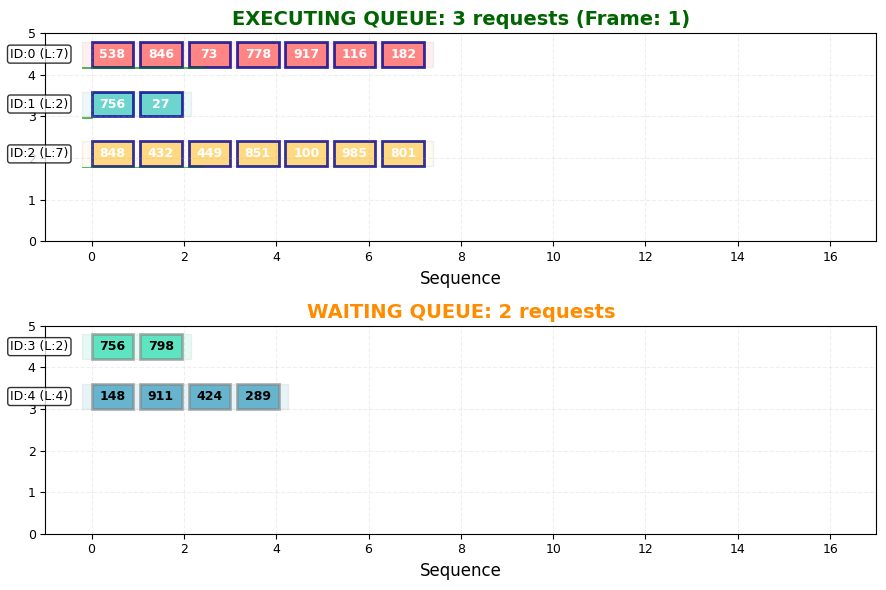

In [13]:
print("静态显示示例:")
engine = Engine()
viz = AdvancedQueueVisualizer()
executing_data, waiting_data = engine.run_engine()
viz.update_display(executing_data, waiting_data)
viz.show()

Continuous Batching示例：

In [ ]:
# prefill处理优先
engine = Engine(totoal_reqs=8)
anim_viz = AnimatedQueueVisualizer(
    data_source_func=engine.run_engine,
    interval=800,  # 800ms每帧
    frames=30      # 30帧
)

# 在Jupyter中显示动画
anim_viz.show_animation()

资源抢占情况示例：

In [ ]:
# num_kvcache_blocks=3 kvcache_block_size=10
# 在处理请求总资源超过总3*10t时，将执行队列的队尾请求转移到等待队列
engine = Engine(totoal_reqs=8, num_kvcache_blocks=3, kvcache_block_size=10)
anim_viz = AnimatedQueueVisualizer(
    data_source_func=engine.run_engine,
    interval=800,
    frames=30
)

# 在Jupyter中显示动画
anim_viz.show_animation()

Decode优先的输出

In [ ]:
# prefill_first设置为False，即Decode优先
engine = Engine(totoal_reqs=10, prefill_first=False)
anim_viz = AnimatedQueueVisualizer(
    data_source_func=engine.run_engine,
    interval=800,
    frames=30
)

# 在Jupyter中显示动画
anim_viz.show_animation()